# Conversation Summaries with LangGraph

- Author: [Junseong Kim](https://www.linkedin.com/in/%EC%A4%80%EC%84%B1-%EA%B9%80-591b351b2/)
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/03-OutputParser/02-CommaSeparatedListOutputParser.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/03-OutputParser/02-CommaSeparatedListOutputParser.ipynb)

## Overview

One of the most common use cases of conversation persistence is keeping track of a conversation's history. By summarizing and referencing past messages, we can maintain essential context without overloading the system with the entire conversation. This becomes especially important for long conversations, where a large context window can lead to increased computational costs and potential inaccuracies. 

In this tutorial, we will explore how to summarize a conversation and integrate that summary into a new conversation state while removing older messages. This approach helps manage the conversation length within a limited context window, preventing inadvertent increases in cost or inference time.

**Key Steps:**

1. Detect if a conversation is too long (e.g., based on the number of messages).
2. If it exceeds a threshold, summarize the conversation so far.
3. Remove older messages and store only the summary (plus the most recent messages).

This tutorial will guide you through setting up a conversation flow that automatically summarizes older messages and retains only the recent conversation turns and the summary.

![](./assets/12-conversation-summaries-with-langgraph_visualize.png)

### Table of Contents
- [Overview](#overview)  
- [Environment Setup](#environment-setup)  
- [Checking the Conversation Length](#checking-the-conversation-length)  
- [Summarizing and Managing the Conversation](#summarizing-and-managing-the-conversation)  
- [Building Graph Workflow](#building-graph-workflow)  
- [Running Workflow](#running-workflow)

### References

- [LangGraph](https://www.langchain.com/langgraph) 
- [LangChain ChatOpenAI API reference](https://python.langchain.com/docs/integrations/llms/openai/)  
- [LangSmith](https://smith.langchain.com)
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langgraph",
        "langchain_core",
        "langchain_openai",
        "langchain_community",
        "IPython",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "12-Conversation-Summaries-with-LangGraph",
    }
)

Environment variables have been set successfully.


You can alternatively set `OPENAI_API_KEY` in `.env` file and load it. 

[Note] This is not necessary if you've already set `OPENAI_API_KEY` in previous steps.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

## Checking the Conversation Length

Below, we set up our custom `State` to store both messages and summaries. We'll also define a helper function in a **separate cell** to determine if the conversation has exceeded a certain length.

- The `State` class extends `MessagesState`, holding `messages` and `summary`.
- We initialize a `ChatOpenAI` model with the name `gpt-4o-mini`.

In [5]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.graph.message import add_messages

# Set up an in-memory storage for conversation states
memory = MemorySaver()


# We'll store both the conversation messages and the summary in the state
class State(MessagesState):
    messages: Annotated[list, add_messages]
    summary: str


# Initialize the LLM model for conversation
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=1)

Here is a separate code cell for the `should_continue` function, which checks if the conversation has more than 6 messages.

In [6]:
from langgraph.graph import END


def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """
    Check if the conversation is too long (over 6 messages).
    If it is, move to the 'summarize_conversation' node.
    Otherwise, end the conversation.
    """
    messages = state["messages"]
    if len(messages) > 6:
        return "summarize_conversation"
    return END

## Summarizing and Managing the Conversation

When the conversation exceeds the threshold, we summarize it and remove older messages to preserve only a recent segment and the overall summary. We also create a node (`ask_llm`) to handle new messages, optionally including the existing summary.

- `ask_llm` checks if a summary exists and prepends it as a `SystemMessage` if so.

In [7]:
def ask_llm(state: State):
    """
    If a summary of the conversation already exists, we include it as a
    system message. Otherwise, we just use the existing messages.
    """
    summary = state.get("summary", "")

    if summary:
        system_message = f"This is the conversation summary so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": [response]}

- `summarize_conversation` either creates or extends a summary and removes older messages.

In [8]:
def summarize_conversation(state: State):
    """
    Summarize the conversation in English.
    If an existing summary exists, extend it with new messages.
    Delete older messages to reduce context usage,
    keeping only the last two messages.
    """
    summary = state.get("summary", "")

    if summary:
        summary_message = (
            f"This is the conversation summary so far:\n{summary}\n\n"
            "Please extend the summary by incorporating any new messages."
        )
    else:
        summary_message = "Please create a concise summary of the conversation so far."

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    # Remove older messages, except the last two
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"summary": response.content, "messages": delete_messages}

## Building Graph Workflow

Here, we construct a `StateGraph`, add our nodes, and compile the application. We also use `visualize_graph(app)` to see how the workflow is structured.

- Use `StateGraph` to define nodes and edges.
- Use `visualize_graph(app)` to see the workflow.

In [9]:
# Build the workflow graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("conversation", ask_llm)
workflow.add_node(summarize_conversation)

# Define edges
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile with memory checkpoint
app = workflow.compile(checkpointer=memory)

Below is an example code snippet that visualizes the current workflow graph. We define custom node styles for the graph and then use IPython utilities to display the rendered image inline. The `NodeStyles` data class customizes fill colors, stroke styles, and overall appearance of the nodes.

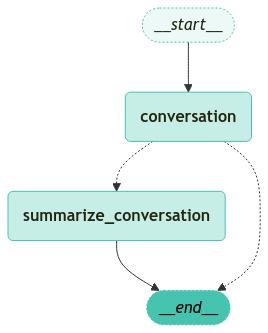

In [ ]:
# Required imports for graph visualization
from IPython.display import Image, display
from dataclasses import dataclass


@dataclass
class NodeStyles:
    """
    A data class defining styles for graph nodes.
    """

    # Style for default nodes
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"
    )
    # Style for first node (e.g., start node)
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:normal, "
        "font-style:italic, stroke-dasharray:2,2"
    )
    # Style for last node (e.g., end node)
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, "
        "stroke:#45C4B0, stroke-width:1px, font-weight:normal, "
        "font-style:italic, stroke-dasharray:2,2"
    )


# Display the workflow graph with the defined node styles
display(
    Image(
        app.get_graph().draw_mermaid_png(
            background_color="white", node_colors=NodeStyles()
        )
    )
)

## Running Workflow

You can interact with the application by sending messages. Once the conversation exceeds 6 messages, it automatically summarizes and shortens.

- The `app.stream` method handles streaming of messages and triggers the nodes accordingly.
- Check the internal state with `app.get_state(config)` to see how messages and summaries are updated.

Here is a helper function, `print_update`, which prints updates in real time during streaming.

In [11]:
def print_update(update):
    """
    Helper function to print out updates during streaming.
    """
    for k, v in update.items():
        for m in v.get("messages", []):
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

Below is a single code cell demonstrating how we handle user messages and process them through streaming mode. We import `HumanMessage`, configure the session with a thread ID, and send three user messages in sequence. After each message, the updates are streamed and printed in real time.

In [12]:
# Initialize a configuration object with thread ID
config = {"configurable": {"thread_id": "1"}}

# 1) First user message
input_message = HumanMessage(content="Hello! Nice to meet you. My name is Junseong.")
input_message.pretty_print()

# Process the first message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 2) Second user message
input_message = HumanMessage(content="Do you remember my name?")
input_message.pretty_print()

# Process the second message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

# 3) Third user message
input_message = HumanMessage(content="I am working as an AI researcher.")
input_message.pretty_print()

# Process the third message in streaming mode and print updates
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Hello! Nice to meet you. My name is Junseong.
================================== Ai Message ==================================

Hello, Junseong! Nice to meet you too! How can I assist you today?
================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, your name is Junseong! How can I help you today?
================================ Human Message =================================

I am working as an AI researcher.
================================== Ai Message ==================================

That's great to hear, Junseong! AI research is a fascinating field with so many exciting developments. What specific area of AI are you focusing on?


So far, no summary has been generated because there are only six messages. Once the conversation exceeds six messages, summarization will be triggered.

In [13]:
values = app.get_state(config).values
values

{'messages': [HumanMessage(content='Hello! Nice to meet you. My name is Junseong.', additional_kwargs={}, response_metadata={}, id='82e87de6-b2bb-43f6-8f5a-98c74569d7ca'),
  AIMessage(content='Hello, Junseong! Nice to meet you too! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 21, 'total_tokens': 41, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7977301-95d5-461f-8c51-373646cb7ab6-0', usage_metadata={'input_tokens': 21, 'output_tokens': 20, 'total_tokens': 41, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Do you reme

You can see that there are only six messages in the list, which is why no summary has been created yet. Let's send another message to exceed that threshold.

In [ ]:
# Create a new user message
input_message = HumanMessage(
    content="I'm recently learning more about LLMs. I'm reading the latest papers on LLM."
)

# Display the message content
input_message.pretty_print()

# Process and print updates in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

I'm recently learning more about LLMs. I'm reading the latest papers on LLM.
================================== Ai Message ==================================

That's an exciting area to explore! Large Language Models (LLMs) have made significant advancements and have a wide range of applications. Are there any specific papers or topics within LLMs that you're particularly interested in or have found intriguing?
================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


================================ Remove Message ================================


Sure!

Because the conversation now has more than six messages, summarization will be triggered.

During this process, old messages are removed, and only the summary plus the last two messages remain in the conversation state.

In [15]:
# Check the conversation state again to see the new summary
values = app.get_state(config).values
values

{'messages': [HumanMessage(content="I'm recently learning more about LLMs. I'm reading the latest papers on LLM.", additional_kwargs={}, response_metadata={}, id='7ba54cd3-47b7-4da9-8867-69aa41cb8914'),
  AIMessage(content="That's an exciting area to explore! Large Language Models (LLMs) have made significant advancements and have a wide range of applications. Are there any specific papers or topics within LLMs that you're particularly interested in or have found intriguing?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 143, 'total_tokens': 191, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-349e654d-3a5c-4b0b-acef-c2c604d6ef40-0', 

As you can see, the summary has been added, and the older messages have been replaced by `RemoveMessage` actions. Only the most recent messages and the newly created summary remain.

You can now continue the conversation, and despite only having the last two messages visible, the system still retains the overall context through the summary.

In [16]:
# Create a user message asking if the assistant remembers the user's name
input_message = HumanMessage(content="Do you remember my name?")
input_message.pretty_print()

# Process in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Do you remember my name?
================================== Ai Message ==================================

Yes, your name is Junseong. How can I assist you further today?


Even though the older messages were removed from the conversation history, the summary contains the essential context. The model can respond accurately based on the stored summary.

In [17]:
# Create another user message asking about the user's occupation
input_message = HumanMessage(content="Do you also recall my occupation?")
input_message.pretty_print()

# Process in streaming mode
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

================================ Human Message =================================

Do you also recall my occupation?
================================== Ai Message ==================================

Yes, you mentioned that you are an AI researcher currently learning about Large Language Models (LLMs). If you have any questions or topics you want to discuss, feel free to share!
